## IMPORT LIBRARIES

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
pip install keras-self-attention

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from keras_self_attention import SeqSelfAttention
import IPython.display as ipd
import json
from google.cloud import storage
from google.oauth2 import service_account

## PATH TO SAMPLE, TRAINING AND TEST DATA

In [17]:
MUSIC_TEST_OUTPUT = 'output'
MUSIC_SAMPLE_PATH = 'sample'
JSON_DATA_FILE = 'processed_data.json'
META_DATA_FILE = 'meta_data.json'
BUCKET_NAME = "bucket-piano-data"
MUSIC_TRAIN_PATH = 'gs://{}/train'.format(BUCKET_NAME)
MUSIC_TEST_PATH = 'gs://{}/{}'.format(BUCKET_NAME, META_DATA_FILE)
MUSIC_VALIDATION_PATH = 'gs://{}/validation'.format(BUCKET_NAME)
META_DATA_PATH = 'gs://{}/train'.format(BUCKET_NAME)

## MODEL PARAMETERS

In [3]:
RNN_CELL_SIZE = 256
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
DECAY_RATE = 1e-5
LOSS_FN = 'binary_crossentropy'
METRICS = ['accuracy']
DROPOUT_RATE = 0.2
RECURRENT_DROPOUT_RATE = 0.2

## LOAD TRAINING DATA AND PARAMETERS FROM JSON FILE

In [19]:
credentials = service_account.Credentials.from_service_account_file('piano-key-generation.json')
storage_client = storage.Client(project='piano-key-generation', credentials=credentials)
bucket = storage_client.get_bucket('bucket-piano-data')

In [ ]:
blob = bucket.get_blob('meta_data.json') 
meta_data = json.loads(blob.download_as_string())

In [ ]:
blob = bucket.get_blob('maestro-v3.0.0.json') 
file_data = json.loads(blob.download_as_string())

## AUDIO PARAMETERS

In [20]:
KEY_FPS = meta_data['key_fps']
HOP_LENGTH = meta_data['hop_length']
WINDOW_SIZE_IN_KEYS = meta_data['windows_size_in_keys']
SAMPLE_RATE = KEY_FPS * HOP_LENGTH
FRAME_SIZE = WINDOW_SIZE_IN_KEYS * HOP_LENGTH
MAX_PIANO_FREQ = meta_data['max_piano_freq']
SEQ_DURATION_SECS = meta_data['seq_length_in_mins']*60
SEQ_LENGTH = meta_data['seq_length']
NUM_UNIQUE_KEYS = 128
notes_to_token = meta_data['notes_to_tokens_dict']
token_to_notes = meta_data['tokens_to_notes_dict']

In [21]:
token_to_notes['0']='0'

(1, 7757, 2048)
(1, 7757)


## GET FILENAMES

In [ ]:
def get_file_names(file_data, bucket, instance_type='train', seq_length=SEQ_DURATION_SECS):
    file_names = []
    for blob in bucket.list_blobs(prefix=instance_type):
        blob = bucket.get_blob(blob.name)
        if blob is not None:
            file_names.append(blob.name)
    return file_names

In [ ]:
train_file_names = get_file_names(file_data, bucket, 'train', SEQ_DURATION_SECS)
test_file_names = get_file_names(file_data, bucket, 'test', SEQ_DURATION_SECS)
validation_file_names = get_file_names(file_data, bucket, 'validation', SEQ_DURATION_SECS)

In [ ]:
print(len(train_file_names))
print(len(test_file_names))
print(len(validation_file_names))

## DEFINE CUSTOM DATA GENERATOR

In [ ]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, bucket, file_names, token_to_notes, meta_data=meta_data, batch_size=BATCH_SIZE, num_unique_keys=NUM_UNIQUE_KEYS):
        self.bucket = bucket
        self.batch_size = batch_size
        self.meta_data = meta_data
        self.num_samples = len(file_names)
        self.file_names = file_names
        self.num_unique_keys = num_unique_keys
        self.token_to_notes = token_to_notes
        
    def __len__(self):
        return (np.ceil(self.num_samples / float(self.batch_size))).astype(np.int)
    
    def convert_label_to_binary(self, output_labels):
        output_binary = []
        for sample in range(output_labels.shape[0]):
            sample_output = output_labels[sample,:]
            sample_output_binary = np.zeros((sample_output.size, self.num_unique_keys))
            for time_step in range(sample_output.size):
                notes_at_time_step = [int(note) for note in self.token_to_notes[str(sample_output[time_step])].split(',')]
                for note in notes_at_time_step:
                    sample_output_binary[time_step, note]=1
            output_binary.append(sample_output_binary)
        output = np.array(output_binary)
        return np.array(output_binary)
    
    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        start_idx = self.batch_size * idx
        for file in self.file_names[start_idx:start_idx+self.batch_size]:
            blob = bucket.get_blob(file)
            json_data = json.loads(json.loads(blob.download_as_string()))
            batch_x.append(json_data['input'])
            batch_y.append(json_data['output'])
        return np.array(batch_x), self.convert_label_to_binary(np.array(batch_y))

In [ ]:
training_batch_generator = CustomDataGenerator(bucket, train_file_names, token_to_notes)
validation_batch_generator = CustomDataGenerator(bucket, validation_file_names, token_to_notes)

## GRU CELL

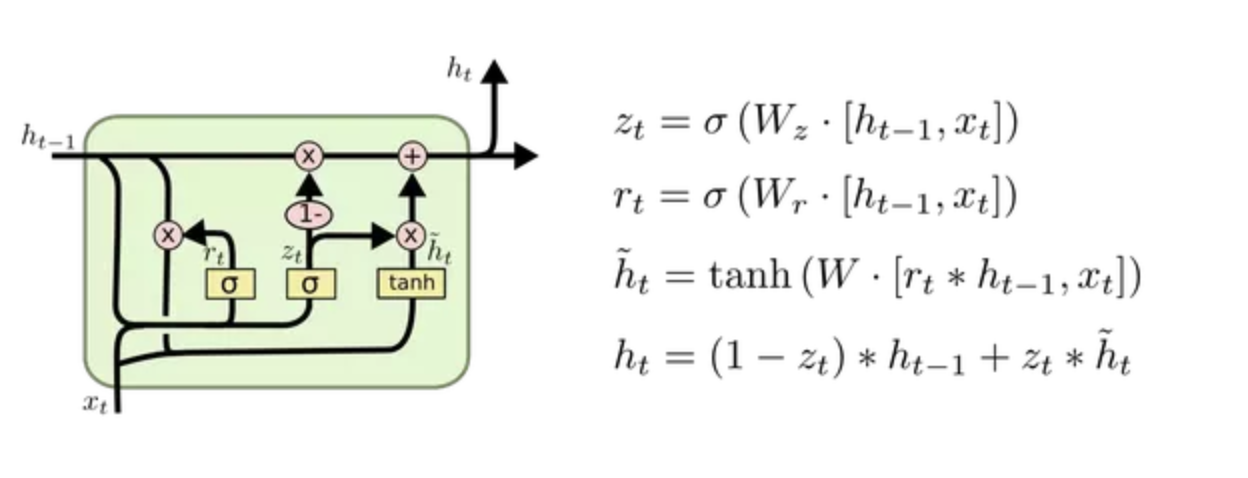

In [25]:
ipd.Image("images/rnn_gru.png")

## SPECIFY MODEL ARCHITECTURE

In [26]:
model = Sequential()
model.add(GRU(RNN_CELL_SIZE, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, MAX_PIANO_FREQ), stateful=True,
                   batch_input_shape=(BATCH_SIZE, SEQ_LENGTH, MAX_PIANO_FREQ), dropout=DROPOUT_RATE, recurrent_dropout=RECURRENT_DROPOUT_RATE))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
# model.add(Dropout(DROPOUT_RATE))
model.add(Dense(NUM_UNIQUE_KEYS))
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (1, None, 128)            836352    
                                                                 
 seq_self_attention (SeqSelf  (1, None, 128)           8257      
 Attention)                                                      
                                                                 
 dense (Dense)               (1, None, 1505)           194145    
                                                                 
Total params: 1,038,754
Trainable params: 1,038,754
Non-trainable params: 0
_________________________________________________________________


## CHOOSE OPTIMIZER AND COMPILE MODEL

In [27]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY_RATE)
model.compile(loss=LOSS_FN, optimizer=optimizer, metrics=METRICS)

## TRAIN MODEL

In [ ]:
model.fit_generator(generator=training_batch_generator, epochs=NUM_EPOCHS, validation_data=validation_batch_generator)

## SAVE MODEL

In [ ]:
model.save('models/gru_attention')